# Interpretable AI on healthcare dataset

### Import necessary libraries

In [44]:
#Internal imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score,classification_report,precision_score,recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import time

### Reading the dataset

In [45]:
data=pd.read_csv('loan-dataset.csv')
data

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


In [46]:
# Showing information about datase
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


### Data Preprocessing

#### Remove unnecessary cols

In [47]:
# Drop the id column --> This attribute is solely used for the identification and does not have other meaningful information
data.drop(columns=['Loan_ID'], inplace=True)
data.columns

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

#### Replace or remove the missing values (NaNs)

In [51]:
data.isna().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [52]:
# Replace the missing values with mean of bmi attribute --> Not removing because it contains 140 records where patients 
# suffered a stroke. This info is valuable and useful.


cleanup_nums = {"Gender":     {"Male": 0, "Female": 1},
                "Married":     {"Yes": 0, "No": 1},
                "Education":     {"Graduate": 0, "Not Graduate": 1},
                "Self_Employed":     {"No": 0, "Yes": 1},
                "Property_Area":     {"Urban": 0, "Rural": 1, "Semiurban": 2},
                "Dependents":     {"0": 0, "1": 1, "2": 2, "3+": 3},
                "Loan_Status":     {"Y": 0, "N": 1}
                }

data = data.replace(cleanup_nums)

data['Gender'].fillna(np.round(data['Gender'].mean(), 1), inplace = True)
data['Married'].fillna(np.round(data['Married'].mean(), 1), inplace = True)
data['Dependents'].fillna(np.round(data['Dependents'].mean(), 1), inplace = True)
data['Self_Employed'].fillna(np.round(data['Self_Employed'].mean(), 1), inplace = True)
data['LoanAmount'].fillna(np.round(data['LoanAmount'].mean(), 1), inplace = True)
data['Loan_Amount_Term'].fillna(np.round(data['Loan_Amount_Term'].mean(), 1), inplace = True)
data['Credit_History'].fillna(np.round(data['Credit_History'].mean(), 1), inplace = True)




### Feature engineering

#### Label Encoding
* The dataset consists of both categorical and numerical values. Since ML understand data of numerical nature, categorical values must be converted to numeric ones using Label Encoder

In [54]:
# Fetch all the cols that has dtypes "object"
cols=data.select_dtypes(include=['object']).columns

# Initializing our Label Encoder object
le=LabelEncoder()

# Transfering categorical data into numeric
data[cols]=data[cols].apply(le.fit_transform)

data.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,0.0,1.0,0.0,0,0.0,5849,0.0,146.4,360.0,1.0,0,0
1,0.0,0.0,1.0,0,0.0,4583,1508.0,128.0,360.0,1.0,1,1
2,0.0,0.0,0.0,0,1.0,3000,0.0,66.0,360.0,1.0,0,0
3,0.0,0.0,0.0,1,0.0,2583,2358.0,120.0,360.0,1.0,0,0
4,0.0,1.0,0.0,0,0.0,6000,0.0,141.0,360.0,1.0,0,0


#### Correlation

<AxesSubplot:>

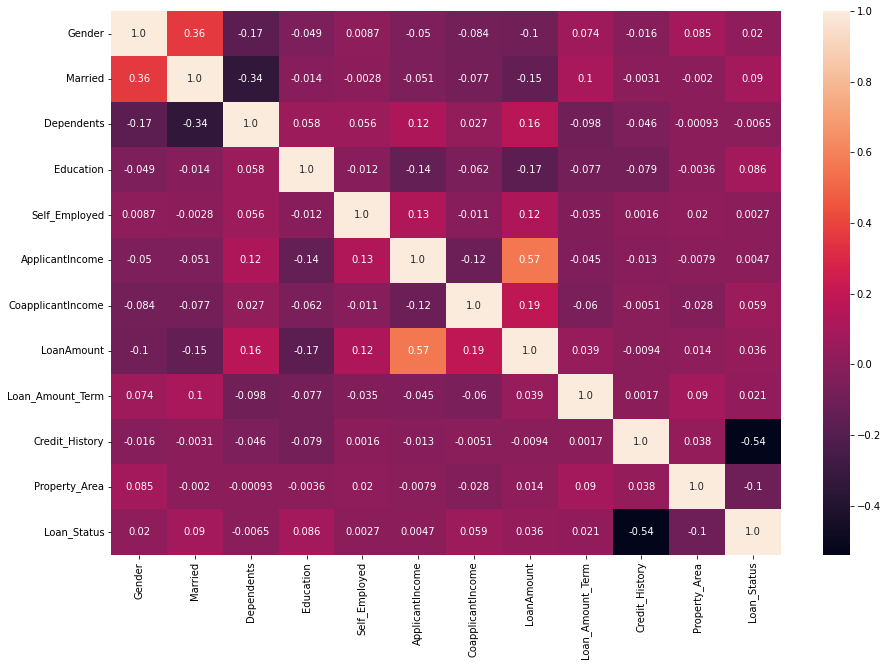

In [55]:
plt.figure(figsize=(15,10))
sns.heatmap(data.corr(),annot=True,fmt='.2')

- age, hypertension, heart_disease, ever_married, avg_glucose_level are showing some effective correlation and hence we consider only these features for further analysis. One can also use SelectKBest and F_Classif functions from scikit-learn package for selecting the best features. 

In [56]:
cols = ['Credit_History', 'Property_Area', 'Dependents']
class_names = ['loan', 'no loan']

### Splitting the dataset

In [57]:
train_x,test_x,train_y,test_y=train_test_split(data[cols],data['Loan_Status'],random_state=1,test_size=0.25)
train_x.shape,test_x.shape,train_y.shape,test_y.shape

((460, 3), (154, 3), (460,), (154,))

### Model training

In [61]:
tree_clf = RandomForestClassifier(max_depth=3, random_state=42)
tree_clf.fit(train_x, train_y)

RandomForestClassifier(max_depth=3, random_state=42)

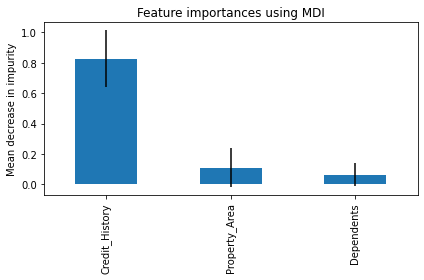

In [65]:
importances = tree_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in tree_clf.estimators_], axis=0)
forest_importances = pd.Series(importances, index=cols)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


### Performance evaluation

In [19]:
predict = tree_clf.predict(test_x)
print('Accuracy --> ', accuracy_score(predict, test_y))

Accuracy -->  0.7922077922077922


### Explanation using Rules

#### Rules in the form of a tree

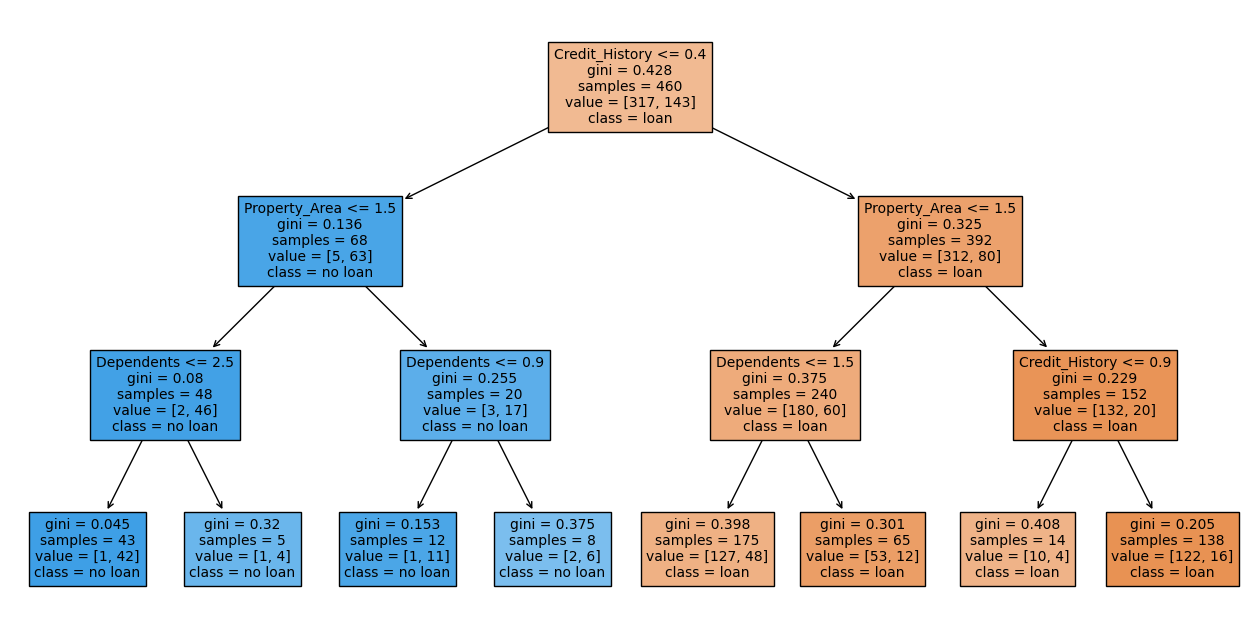

In [20]:
 # plot tree
plt.figure(figsize=(16,8))  # set plot size (denoted in inches)
tree.plot_tree(tree_clf, 
               feature_names = cols,
               class_names = class_names,
               fontsize=10,
               filled=True)
plt.show()

##### Rules in the form of text

In [ ]:
text_representation = tree.export_text(tree_clf,
                                      feature_names=cols)
print(text_representation)

|--- age <= 67.50
|   |--- age <= 47.50
|   |   |--- age <= 37.50
|   |   |   |--- class: 0
|   |   |--- age >  37.50
|   |   |   |--- class: 0
|   |--- age >  47.50
|   |   |--- avg_glucose_level <= 150.81
|   |   |   |--- class: 0
|   |   |--- avg_glucose_level >  150.81
|   |   |   |--- class: 0
|--- age >  67.50
|   |--- ever_married <= 0.50
|   |   |--- hypertension <= 0.50
|   |   |   |--- class: 0
|   |   |--- hypertension >  0.50
|   |   |   |--- class: 1
|   |--- ever_married >  0.50
|   |   |--- avg_glucose_level <= 238.80
|   |   |   |--- class: 0
|   |   |--- avg_glucose_level >  238.80
|   |   |   |--- class: 0



In [ ]:
# !pip install pysbrl
# !pip install pyfim

# from pysbrl import BayesianRuleList

# rule_list = BayesianRuleList(min_rule_len=1, max_rule_len=2, min_support=0.01)
# rule_id, outputs, raw_rules = rule_list.fit(train_x, train_y)
# rule_list.fit()

     |████████████████████████████████| 357 kB 5.3 MB/s 
  Created wheel for pyfim: filename=pyfim-6.28-cp37-cp37m-linux_x86_64.whl size=537766 sha256=92badc44f77d16ef89d1ef60884be533402a28230dad48901046171758d29fab
  Stored in directory: /root/.cache/pip/wheels/08/9f/26/09cb4efd027e46f96e0a0f33d0a74be614d3caf89c1eeb75a8
Successfully built pyfim
